# **Bank Churn Prediction Model**

## **Problem Statement**
1.

2.

3.

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')
import logging
logging.basicConfig(level = logging.INFO,
                    filename = 'model.log',
                    filemode = 'w',
                    format = '%(name)s - %(levelname)s - %(message)s',
                    force=True)

In [ ]:
# Set Style
sns.set_style('darkgrid')
sns.set_context('notebook')

In [ ]:
# Data Ingestion Function
def data_ingestion():
  return pd.read_csv('/content/Churn_Modelling.csv')

In [ ]:
# Data Exploration Function
from collections import OrderedDict

def exploration(df):

    numerical_col = df.select_dtypes(exclude='object').columns
    categorical_col = df.select_dtypes(include='object').columns

    num = []
    cat = []
    info = []

    # Numerical Features ----------
    for i in numerical_col:
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3 - Q1
        LW = Q1 - (1.5 * IQR)
        UW = Q3 + (1.5 * IQR)

        Outlier_Count = ((df[i] < LW) | (df[i] > UW)).sum()
        Outlier_Percentage = (Outlier_Count / len(df)) * 100

        numerical_stats = OrderedDict({
            "Feature": i,
            "Count": df[i].count(),
            "Maximum": df[i].max(),
            "Minimum": df[i].min(),
            "Mean": df[i].mean(),
            "Median": df[i].median(),
            "Q1": Q1,
            "Q3": Q3,
            "IQR": IQR,
            "Lower_Whisker": LW,
            "Upper_Whisker": UW,
            "Outlier_Count": Outlier_Count,
            "Outlier_Percentage": Outlier_Percentage
        })

        num.append(numerical_stats)

    numerical_stats_report = pd.DataFrame(num)

    # Categorical Features ----------
    for j in categorical_col:
        categorical_stats = OrderedDict({
            "Feature": j,
            "Count": df[j].count(),
            "Unique_Values": df[j].nunique(),
            "Value_Counts": df[j].value_counts()
        })
        cat.append(categorical_stats)

    categorical_stats_report = pd.DataFrame(cat)

    # Dataset Info ----------
    for k in df.columns:
        info_stats = OrderedDict({
            "Feature": k,
            "Data_Type": df[k].dtype,
            "Null_Count": df[k].isnull().sum(),
            "Null_Percentage": (df[k].isnull().sum() / len(df)) * 100
        })
        info.append(info_stats)

    info_stats_report = pd.DataFrame(info)

    return numerical_stats_report, categorical_stats_report, info_stats_report

In [ ]:
# Crosstab Function Definition
def crosstab(df):
  crosstab1 = pd.crosstab(index = df['Geography'],columns = [df['Exited'],df['Tenure']],margins=True)
  crosstab2 = pd.crosstab(df['Age'],df['Exited'],margins = True)
  crosstab3 = pd.crosstab(df['Tenure'],df['Exited'],margins = True)
  crosstab4 = pd.crosstab(df['EstimatedSalary'],df['Exited'],margins = True)
  crosstab5 = pd.crosstab(df['HasCrCard'],df['Exited'],margins = True)

  return crosstab1,crosstab2,crosstab3,crosstab4,crosstab5

In [ ]:
# Preprocessing function defintion
from sklearn.preprocessing import MinMaxScaler,RobustScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

def preprocessing(df):

  X = df.drop(columns = ['RowNumber', 'CustomerId', 'Surname','Exited'],axis = 1)
  y = df['Exited']

  X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                   test_size = 0.3,
                                                   random_state = 0)

  le = LabelEncoder()

  for i in X_train.columns:
    if X_train[i].dtype == 'object':
      X_train[i] = le.fit_transform(X_train[i])  # fit_train is always with seen Data
      X_test[i] = le.transform(X_test[i])  # transform is always with Unseen Data

  sc = RobustScaler()
  X_train = sc.fit_transform(X_train) # fit_train is always with seen Data
  X_test = sc.transform(X_test)  # transform is always with Unseen Data

  smote = SMOTE() # Using Over Sampling Technique
  X_train,y_train = smote.fit_resample(X_train,y_train) # Balancing Seen Data

  return X_train,X_test,y_train,y_test

In [ ]:
# Model building function
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.neighbors import KNeighborsClassifier

def model_build(X_train,X_test,y_train,y_test):

  models = {
      'LogisticRegression': LogisticRegression(),
      'DecisionTreeClassifier': DecisionTreeClassifier(),
      'RandomForestClassifier': RandomForestClassifier(),
      'GradientBoostingClassifier': GradientBoostingClassifier(),
      'AdaBoostClassifier': AdaBoostClassifier(),
      'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=10)
  }

  model_performance = []

  for model_name,model in models.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    report = classification_report(y_test,y_pred)

    report = OrderedDict({
        'Model_Name': model_name,
        'Accuracy_Score': accuracy_score(y_test,y_pred),
        'Confusion_Matrix': confusion_matrix(y_test,y_pred),
        'Classification_Report': report})

    model_performance.append(report)

  model_performance = pd.DataFrame(model_performance)
  return model_performance


In [ ]:
from imblearn.over_sampling._smote.base import mode
# function calling

df = data_ingestion()

numerical_stats_report,categorical_stats_report,info_stats_report = exploration(df)

crosstab1,crosstab2,crosstab3,crosstab4,crosstab5 = crosstab(df)

X_train,X_test,y_train,y_test = preprocessing(df)

model_performance = model_build(X_train,X_test,y_train,y_test)

## **Exploratory Data Analysis**

In [ ]:
df.sample(frac = 1)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9161,9162,15750049,Steele,621,France,Male,40,10,163823.37,1,0,0,89519.47,0
2890,2891,15689616,Ward,586,Spain,Male,34,5,168094.01,1,0,0,20058.61,0
9739,9740,15797293,Sopuluchukwu,677,France,Female,25,3,0.00,2,1,0,179608.96,0
6077,6078,15738588,Nebechi,660,Germany,Female,37,2,133200.09,1,0,0,71433.88,0
5286,5287,15690540,Gearheart,684,Spain,Female,41,1,134177.06,1,0,0,177506.66,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9743,9744,15609643,Furneaux,752,Germany,Male,32,9,115587.49,2,0,1,101677.46,0
4572,4573,15799964,Campbell,669,Germany,Female,30,7,139872.81,1,1,0,188795.85,0
800,801,15747542,Perez,605,France,Male,52,7,0.00,2,1,1,173952.50,0
8092,8093,15663770,Doyle,802,France,Male,38,1,142557.11,1,1,1,172497.73,0


In [ ]:
# Checking Descriptive stats : Numerical columns
numerical_stats_report

,Feature,Count,Maximum,Minimum,Mean,Median,Q1,Q3,IQR,Lower_Whisker,Upper_Whisker,Outlier_Count,Outlier_Percentage
0,RowNumber,10000,10000.00,1.00,5.000500e+03,5.000500e+03,2500.75,7.500250e+03,4999.5000,-4.998500e+03,1.499950e+04,0,0.00
1,CustomerId,10000,15815690.00,15565701.00,1.569094e+07,1.569074e+07,15628528.25,1.575323e+07,124705.5000,1.544147e+07,1.594029e+07,0,0.00
2,CreditScore,10000,850.00,350.00,6.505288e+02,6.520000e+02,584.00,7.180000e+02,134.0000,3.830000e+02,9.190000e+02,15,0.15
3,Age,10000,92.00,18.00,3.892180e+01,3.700000e+01,32.00,4.400000e+01,12.0000,1.400000e+01,6.200000e+01,359,3.59
4,Tenure,10000,10.00,0.00,5.012800e+00,5.000000e+00,3.00,7.000000e+00,4.0000,-3.000000e+00,1.300000e+01,0,0.00
5,Balance,10000,250898.09,0.00,7.648589e+04,9.719854e+04,0.00,1.276442e+05,127644.2400,-1.914664e+05,3.191106e+05,0,0.00
6,NumOfProducts,10000,4.00,1.00,1.530200e+00,1.000000e+00,1.00,2.000000e+00,1.0000,-5.000000e-01,3.500000e+00,60,0.60
7,HasCrCard,10000,1.00,0.00,7.055000e-01,1.000000e+00,0.00,1.000000e+00,1.0000,-1.500000e+00,2.500000e+00,0,0.00
8,IsActiveMember,10000,1.00,0.00,5.151000e-01,1.000000e+00,0.00,1.000000e+00,1.0000,-1.500000e+00,2.500000e+00,0,0.00
9,EstimatedSalary,10000,199992.48,11.58,1.000902e+05,1.001939e+05,51002.11,1.493882e+05,98386.1375,-9.657710e+04,2.969675e+05,0,0.00


In [ ]:
# Checking Descriptive stats : Categorical columns
categorical_stats_report

,Feature,Count,Unique_Values,Value_Counts
0,Surname,10000,2932,Surname Smith 32 Scott 29 Martin...
1,Geography,10000,3,Geography France 5014 Germany 2509 Spai...
2,Gender,10000,2,Gender Male 5457 Female 4543 Name: cou...


In [ ]:
# Checking Dataset Information
info_stats_report

,Feature,Data_Type,Null_Count,Null_Percentage
0,RowNumber,int64,0,0.0
1,CustomerId,int64,0,0.0
2,Surname,object,0,0.0
3,CreditScore,int64,0,0.0
4,Geography,object,0,0.0
5,Gender,object,0,0.0
6,Age,int64,0,0.0
7,Tenure,int64,0,0.0
8,Balance,float64,0,0.0
9,NumOfProducts,int64,0,0.0


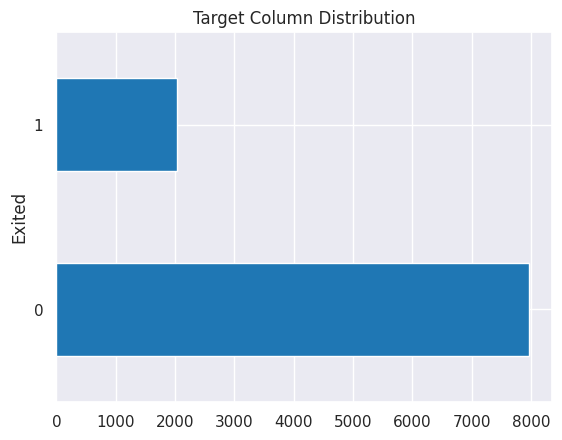

In [ ]:
# Understanding target column: Exited (Distribution)

df['Exited'].value_counts().plot(kind = 'barh')
plt.title('Target Column Distribution')
plt.show()

In [ ]:
# Crosstab reports
crosstab1.to_csv('crosstab1.csv')
crosstab1

Exited       0                                               ...    1       \
Tenure       0    1    2    3    4    5    6    7    8    9  ...    2    3   
Geography                                                    ...             
France     170  446  435  408  427  409  426  476  396  416  ...   90   83   
Germany     69  159  211  177  156  169  151  164  177  176  ...   64   84   
Spain       79  198  201  211  203  225  194  211  255  179  ...   47   46   
All        318  803  847  796  786  803  771  851  828  771  ...  201  213   

Exited                                          All  
Tenure       4    5    6    7    8    9   10         
Geography                                            
France      85   76   77   76   69   88   48   5014  
Germany     76   90   76   61   87   93   42   2509  
Spain       42   43   43   40   41   32   11   2477  
All        203  209  196  177  197  213  101  10000  

[4 rows x 23 columns]

In [ ]:
crosstab2.to_csv('crosstab2.csv')
crosstab2.T

Age,18,19,20,21,22,23,24,25,26,27,...,79,80,81,82,83,84,85,88,92,All
Exited,,,,,,,,,,,,,,,,,,,,,
0,20,26,38,50,72,93,118,148,186,196,...,4,3,4,1,1,1,1,1,2,7963
1,2,1,2,3,12,6,14,6,14,13,...,0,0,0,0,0,1,0,0,0,2037
All,22,27,40,53,84,99,132,154,200,209,...,4,3,4,1,1,2,1,1,2,10000


In [ ]:
crosstab3.to_csv('crosstab3.csv')
crosstab3.T

Tenure,0,1,2,3,4,5,6,7,8,9,10,All
Exited,,,,,,,,,,,,
0,318,803,847,796,786,803,771,851,828,771,389,7963
1,95,232,201,213,203,209,196,177,197,213,101,2037
All,413,1035,1048,1009,989,1012,967,1028,1025,984,490,10000


In [ ]:
crosstab4.to_csv('crosstab4.csv')
crosstab4.T

EstimatedSalary,11.58,90.07,91.75,96.27,106.67,123.07,142.81,143.34,178.19,216.27,...,199808.1,199841.32,199857.47,199862.75,199909.32,199929.17,199953.33,199970.74,199992.48,All
Exited,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,1,1,0,1,1,1,1,...,0,1,1,1,1,1,1,1,1,7963
1,1,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2037
All,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,10000


In [ ]:
crosstab5.to_csv('crosstab5.csv')
crosstab5.T

HasCrCard,0,1,All
Exited,,,
0,2332,5631,7963
1,613,1424,2037
All,2945,7055,10000


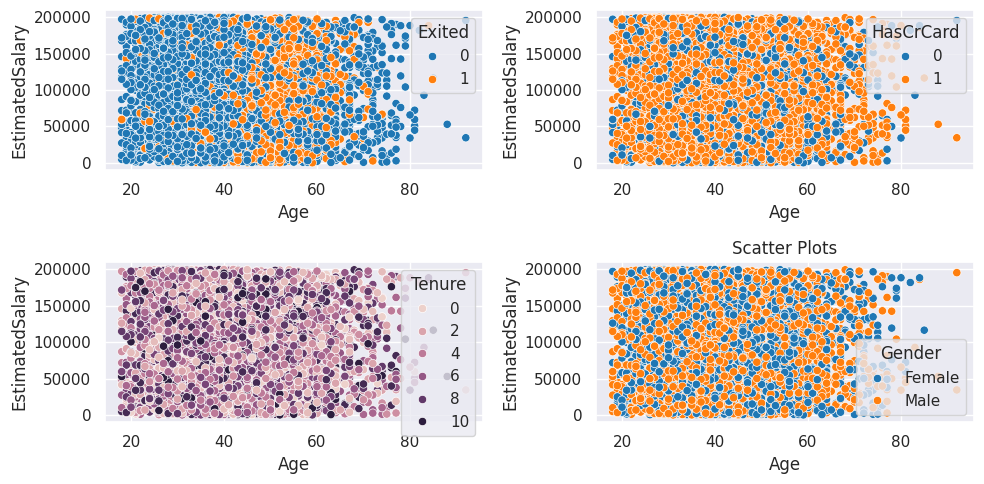

In [ ]:
# Plotting function

fig,ax = plt.subplots(2,2,figsize = (10,5))
sns.scatterplot(data = df,x = 'Age',y = 'EstimatedSalary',hue = 'Exited',ax = ax[0][0])
sns.scatterplot(data = df,x = 'Age',y = 'EstimatedSalary',hue = 'HasCrCard',ax = ax[0][1])
sns.scatterplot(data = df,x = 'Age',y = 'EstimatedSalary',hue = 'Tenure',ax = ax[1][0])
sns.scatterplot(data = df,x = 'Age',y = 'EstimatedSalary',hue = 'Gender',ax = ax[1][1])
plt.title('Scatter Plots')
plt.tight_layout()
plt.show()

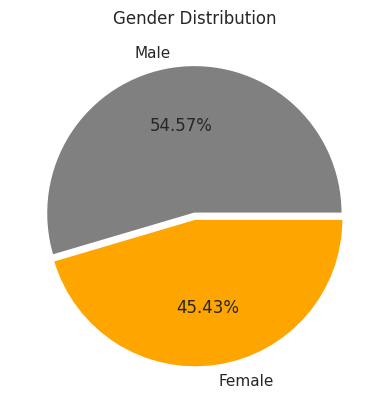

In [ ]:
# Gender distribution w.r.t Exited

colors = ['gray', 'orange']

df['Gender'].value_counts().plot(
    kind='pie',
    autopct='%1.2f%%',
    explode=[0.02, 0.02],
    colors=colors
)
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()


In [ ]:
# prepare report based on gender w.r.t Exited status
Male_Exited = df[(df['Gender'] == 'Male') & (df['Exited'] == 1)]
Female_Exited = df[(df['Gender'] == 'Female') & (df['Exited'] == 1)]
Male_NotExited = df[(df['Gender'] == 'Male') & (df['Exited'] == 0)]
Female_NotExited = df[(df['Gender'] == 'Female') & (df['Exited'] == 0)]

In [ ]:
# Preparing csv file based on crosstab report
crosstab1 = pd.DataFrame(crosstab1)
crosstab1.to_csv('crosstab1.csv')
Male_Exited.to_csv('Male_Exited.csv')
Female_Exited.to_csv('Female_Exited.csv')
Male_NotExited.to_csv('Male_NotExited.csv')
Female_NotExited.to_csv('Female_NotExited.csv')
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [ ]:
model_performance.sort_values(by = 'Accuracy_Score',ascending = True)

,Model_Name,Accuracy_Score,Confusion_Matrix,Classification_Report
0,LogisticRegression,0.699000,"[[1661, 718], [185, 436]]",precision recall f1-score ...
5,KNeighborsClassifier,0.759667,"[[1864, 515], [206, 415]]",precision recall f1-score ...
1,DecisionTreeClassifier,0.769667,"[[1949, 430], [261, 360]]",precision recall f1-score ...
4,AdaBoostClassifier,0.772333,"[[1841, 538], [145, 476]]",precision recall f1-score ...
3,GradientBoostingClassifier,0.823333,"[[2039, 340], [190, 431]]",precision recall f1-score ...
2,RandomForestClassifier,0.845000,"[[2154, 225], [240, 381]]",precision recall f1-score ...


In [ ]:
model_performance.to_csv('model_performance.csv')